In [2]:
# Library to dataset
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Library tensorflow
import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer, tokenizer_from_json
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# Surpress warning
import warnings
warnings.filterwarnings("ignore")

# Library sklearn
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# pickle
import pickle

# Dataset

In [3]:
# Read dataset
data = pd.read_csv('/kaggle/input/suicide-detection-clean/clean_text.csv')
data.head()

,text,class,clean_text
0,Ex Wife Threatening SuicideRecently I left my ...,suicide,ex wife threatening suiciderecently left wife ...
1,Am I weird I don't get affected by compliments...,non-suicide,weird get affected compliments coming someone ...
2,Finally 2020 is almost over... So I can never ...,non-suicide,finally almost never hear bad year ever swear ...
3,i need helpjust help me im crying so hard,suicide,need helpjust help im crying hard
4,"I’m so lostHello, my name is Adam (16) and I’v...",suicide,losthello name adam struggling years afraid pa...


# Encoding

In [4]:
X = data['clean_text'].astype(str)
y = data['class']

# encode class values as integers
# Define label encoder
encoder = LabelEncoder()
# fit and transform
encoded_y = encoder.fit_transform(y)

In [5]:
encoded_y[:10]

array([1, 0, 0, 1, 1, 1, 1, 1, 0, 1])

# Test Train Split

In [6]:
# Test and train split
X_train, X_test, y_train, y_test = train_test_split(X, encoded_y, test_size=.2, random_state=42)

# Data Preprocessing

In [7]:
vocab_size = 1000
max_length = 1000
trunc_type='post'
padding_type='post'
oov_tok = "<OOV>"

# Initialize the Tokenizer class
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_tok)
# Generate the word index dictionary

tokenizer.fit_on_texts(X_train)

# Tokenizer Save
tokenizer_json = tokenizer.to_json()
with open("tokenizer.json", "w", encoding="utf-8") as f:
    f.write(tokenizer_json)

In [8]:
# Tokenizer read
with open("tokenizer.json", "r", encoding="utf-8") as f:
    json_file = f.read()

tokenizer = tokenizer_from_json(json_file)

In [9]:
word_index = tokenizer.word_index
# Convert the labels lists into numpy arrays
training_labels = np.array(y_train)
testing_labels = np.array(y_test)

# Generate and pad the training sequences
training_sequences = tokenizer.texts_to_sequences(X_train)
training_padded = pad_sequences(training_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# Generate and pad the testing sequences
testing_sequences = tokenizer.texts_to_sequences(X_test)
testing_padded = pad_sequences(testing_sequences, maxlen=max_length, padding=padding_type, truncating=trunc_type)

# List Resource

In [10]:
# Lis physical devices
devices = tf.config.experimental.list_physical_devices('GPU')
devices

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'),
 PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]

In [11]:
# Define the GPU strategy
mirrored_strategy = tf.distribute.MirroredStrategy(devices=["/gpu:0", "/gpu:1"])

# Bidirectional LSTM 1 Layer

In [12]:
embedding_dim = 16
with mirrored_strategy.scope():
# Initialize the model
    model = tf.keras.Sequential([
        tf.keras.layers.Embedding(vocab_size, embedding_dim, input_length=max_length),
        tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])

    # Compile the model
    model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
    
# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ ?                           │     0 (unbuilt) │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ ?                           │     0 (unbuilt) │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [13]:
# Difine the callbacks
# Save the best model
checkpoint_callback = ModelCheckpoint(filepath="Bidirectional-LSTM-1-Layers.keras", save_best_only=True, monitor="val_accuracy", mode="max", verbose=1)

# Early stopping
early_stopping_callback = EarlyStopping(monitor="val_accuracy", mode="max", patience=5, verbose=1, restore_best_weights=True)

# Reduce learning rate
reduce_lr_callback = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, verbose=1, mode="min", min_delta=0.0001, cooldown=0, min_lr=0)

# Callbacks list
callbacks=[checkpoint_callback, early_stopping_callback, reduce_lr_callback]

In [14]:
# Define the number of epochs
num_epochs = 10

# Train the model
history = model.fit(training_padded, training_labels, epochs=num_epochs, validation_data=(testing_padded, testing_labels), callbacks=callbacks, batch_size=128)

Epoch 1/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.8809 - loss: 0.2895
Epoch 1: val_accuracy improved from -inf to 0.91865, saving model to Bidirectional-LSTM-1-Layers.keras
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 117s 76ms/step - accuracy: 0.8810 - loss: 0.2894 - val_accuracy: 0.9186 - val_loss: 0.2153 - learning_rate: 0.0010
Epoch 2/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step - accuracy: 0.9200 - loss: 0.2136
Epoch 2: val_accuracy improved from 0.91865 to 0.91981, saving model to Bidirectional-LSTM-1-Layers.keras
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 109s 75ms/step - accuracy: 0.9200 - loss: 0.2136 - val_accuracy: 0.9198 - val_loss: 0.2107 - learning_rate: 0.0010
Epoch 3/10
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.9222 - loss: 0.2045
Epoch 3: val_accuracy did not improve from 0.91981
1451/1451 ━━━━━━━━━━━━━━━━━━━━ 108s 74ms/step - accuracy: 0.9222 - loss: 0.2045 - val_accuracy: 0.9190 - val_loss: 0.2173 - learning_rate: 0.0010
Epoch 4/10
1451/1451 ━━━━━━━━━━━━━━

In [15]:
# Evaluate the model
results_base = model.evaluate(testing_padded, testing_labels)

# print results
print(f'Test results - Loss: {results_base[0]} - Accuracy: {100*results_base[1]}%')

1451/1451 ━━━━━━━━━━━━━━━━━━━━ 41s 28ms/step - accuracy: 0.9253 - loss: 0.1972
Test results - Loss: 0.19227153062820435 - Accuracy: 92.66201257705688%


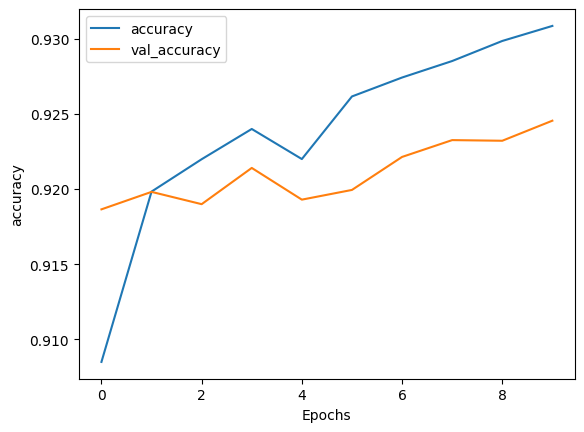

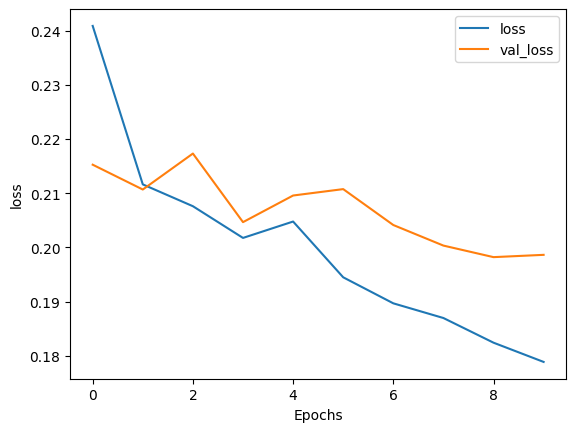

In [16]:
# Plot utility
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
# Plot the accuracy and loss
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

# Testing Model

In [17]:
# Load all model
BiLSTM1L_Model = tf.keras.models.load_model('Bidirectional-LSTM-1-Layers.keras')

## Testing BiLSTM 1 Layers

In [ ]:
twt = [ str(input()) ]
twt = tokenizer.texts_to_sequences(twt)
twt = pad_sequences(twt, maxlen=max_length, padding=padding_type, truncating=trunc_type)

prediction = BiLSTM1L_Model.predict(twt)

# Print the prediction
if(prediction[0][0] >= 0.5):
    print("Potential Suicide Post")
else:
    print("Non Suicide Post")